In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from zNet import one_hot, decode_label
from torch.utils.data import Dataset, DataLoader

In [2]:
data = (pd.read_csv("data/train.csv")).values
# Shuffle the data
np.random.shuffle(data)

# Split the test/train dataset
m, n = data.shape
test_ratio = 0.25

m_test = int(m * 0.25)
X_test = data[:m_test, 1:] / 255
y_test = data[:m_test, 0]

X_train = data[m_test:, 1:] / 255
y_train = data[m_test:, 0]

In [3]:
X_train.shape

(31500, 784)

In [4]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


In [6]:
batch_size = 256
# Instantiate training and test data
train_data = Data(X_train, one_hot(y_train))
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, one_hot(y_test))
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 0
X shape: torch.Size([256, 784])
y shape: torch.Size([256, 10])


### 0. Load Tensor

In [7]:
X = torch.tensor(X_train, dtype=torch.float)
y = torch.tensor(one_hot(y_train), dtype=torch.int)

In [8]:
X.shape, y.shape

(torch.Size([31500, 784]), torch.Size([31500, 10]))

### 1. Set up the Neural Net

In [15]:
input_dim = X.shape[1]
hidden_dim = 16
output_dim = 10


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.hidden_1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.output = nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.softmax(self.hidden_1(x), dim=1)
        return self.output(x)


In [16]:
model = Net(input_dim, hidden_dim, output_dim)

In [17]:
print(model)

Net(
  (input): Linear(in_features=784, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
)


In [18]:
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training

In [21]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


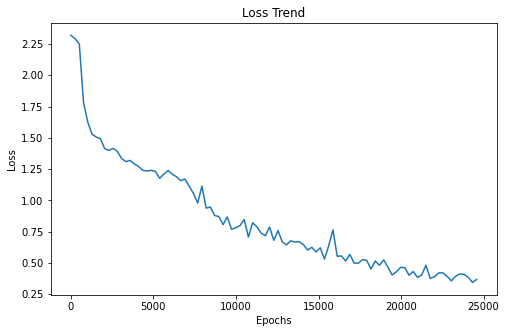

In [22]:
## Visualize the loss track
fig, ax = plt.subplots(figsize=(8,5))
idx_arr = np.arange(0, len(loss_values), batch_size)

plt.plot(idx_arr, np.array(loss_values)[idx_arr])
plt.title("Loss Trend")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Save Model

In [25]:
model.state_dict()

OrderedDict([('input.weight',
              tensor([[ 0.0133,  0.0246, -0.0155,  ...,  0.0249, -0.0138,  0.0038],
                      [ 0.0130,  0.0112, -0.0193,  ...,  0.0321,  0.0303,  0.0340],
                      [ 0.0121,  0.0282, -0.0343,  ..., -0.0165, -0.0110,  0.0333],
                      ...,
                      [-0.0190,  0.0033, -0.0231,  ..., -0.0278, -0.0059, -0.0298],
                      [-0.0023, -0.0252,  0.0345,  ...,  0.0030, -0.0266, -0.0346],
                      [ 0.0138,  0.0097, -0.0242,  ...,  0.0116, -0.0075,  0.0091]])),
             ('input.bias',
              tensor([ 0.4284,  0.4552,  0.9448,  0.6951,  0.6188,  0.3906,  0.2328,  0.5749,
                      -0.0612, -0.0373,  0.1867,  0.6174,  0.4501,  0.6217,  0.2460,  0.3304])),
             ('hidden_1.weight',
              tensor([[-2.6142e-01,  3.2357e-02, -3.2492e-01, -5.5915e-03, -5.4564e-02,
                       -3.4465e-01, -4.1773e-02, -3.1619e-01,  1.5825e-01, -3.0626e-01,
        

In [26]:
torch.save(model.state_dict(), "data/nn.model")

In [27]:
nn_model = torch.load("data/nn.model")

### Test Set

In [28]:
pred_test = model(torch.from_numpy(X_test.astype(np.float32)))

In [29]:
pred_test

tensor([[ -6.3783,  -2.0531,   5.6147,  ...,  -7.2414,   0.6368,   0.6362],
        [  1.7345,  -4.4607,  -1.8506,  ...,  -3.4721,   4.7594,  -0.3268],
        [ -1.9261,  -7.3968,   3.7787,  ...,  -8.7056,   0.2695,   1.6610],
        ...,
        [  5.8255,  -8.0748,  -4.2319,  ...,  -3.7847,   5.2761,   0.0715],
        [ -4.4096,  -4.1567,  -1.3089,  ...,  10.4200,   0.2520,   8.0422],
        [ 10.8311, -12.6647,  -7.0850,  ...,  -4.2104,   5.7917,   0.6660]],
       grad_fn=<AddmmBackward0>)

In [30]:
pred_test.detach().numpy()

array([[ -6.3783083 ,  -2.0531213 ,   5.6147146 , ...,  -7.2413964 ,
          0.63680077,   0.6361561 ],
       [  1.7345004 ,  -4.4607353 ,  -1.8505732 , ...,  -3.4720848 ,
          4.759417  ,  -0.3267703 ],
       [ -1.9260584 ,  -7.3967915 ,   3.7786503 , ...,  -8.705599  ,
          0.2695459 ,   1.660973  ],
       ...,
       [  5.8254995 ,  -8.074768  ,  -4.231863  , ...,  -3.7846956 ,
          5.276064  ,   0.07146442],
       [ -4.40962   ,  -4.156661  ,  -1.3089072 , ...,  10.4199505 ,
          0.252012  ,   8.042166  ],
       [ 10.8311    , -12.664668  ,  -7.0849814 , ...,  -4.21039   ,
          5.791729  ,   0.666     ]], dtype=float32)

### Numpy Model

In [31]:
nn_model

OrderedDict([('input.weight',
              tensor([[ 0.0133,  0.0246, -0.0155,  ...,  0.0249, -0.0138,  0.0038],
                      [ 0.0130,  0.0112, -0.0193,  ...,  0.0321,  0.0303,  0.0340],
                      [ 0.0121,  0.0282, -0.0343,  ..., -0.0165, -0.0110,  0.0333],
                      ...,
                      [-0.0190,  0.0033, -0.0231,  ..., -0.0278, -0.0059, -0.0298],
                      [-0.0023, -0.0252,  0.0345,  ...,  0.0030, -0.0266, -0.0346],
                      [ 0.0138,  0.0097, -0.0242,  ...,  0.0116, -0.0075,  0.0091]])),
             ('input.bias',
              tensor([ 0.4284,  0.4552,  0.9448,  0.6951,  0.6188,  0.3906,  0.2328,  0.5749,
                      -0.0612, -0.0373,  0.1867,  0.6174,  0.4501,  0.6217,  0.2460,  0.3304])),
             ('hidden_1.weight',
              tensor([[-2.6142e-01,  3.2357e-02, -3.2492e-01, -5.5915e-03, -5.4564e-02,
                       -3.4465e-01, -4.1773e-02, -3.1619e-01,  1.5825e-01, -3.0626e-01,
        

In [32]:
W1 = nn_model['input.weight'].detach().numpy()
b1 = nn_model['input.bias'].detach().numpy()
W2 = nn_model['hidden_1.weight'].detach().numpy()
b2 = nn_model['hidden_1.bias'].detach().numpy()
W3 = nn_model['output.weight'].detach().numpy()
b3 = nn_model['output.bias'].detach().numpy()

In [33]:
W1.shape, b1.shape

((16, 784), (16,))

In [34]:
W2.shape, b2.shape

((16, 16), (16,))

In [35]:
W3.shape, b3.shape

((10, 16), (10,))

In [ ]:
X_test.shape, y_test.shape

In [47]:
def ReLU(z):
    return z.clip(0,)

def softmax(z):
    ez = np.exp(z)
    # normalize over the column
    return ez/ ez.sum(axis=0)

def np_model(x):
    z1 = W1 @ x.T + b1.reshape(len(b1), 1)
    A1 = ReLU(z1)
    z2 = W2 @ A1 + b2.reshape(len(b2),1)
    A2 = softmax(z2)
    return (W3 @ A2 + b3.reshape(len(b3),1)).T


In [50]:
((np_model(X_test) - pred_test.detach().numpy())**2).sum()

1.3168172606280846e-07

In [49]:
pred_test.detach().numpy().shape

(10500, 10)